In [1]:
!pip3 install pandas
!pip3 install seaborn
!pip3 install --upgrade tensorflow-gpu
!pip3 install import-ipynb

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
import pickle

import import_ipynb
import VariationalAutoencoderModel

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, mean_squared_error, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
importing Jupyter notebook from VariationalAutoencoderModel.ipynb
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction = 0.333)
sess = tf.compat.v1.Session(config = tf.compat.v1.ConfigProto(gpu_options = gpu_options))

# Simple Home 1002 Camera Data Pre-Processing

In [3]:
# Benign traffic

s2_benign = pd.read_csv('nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_s2_benign = s2_benign.copy(deep=True)

# Mirai

s2_mirai_ack = pd.read_csv('nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/mirai/ack.csv', encoding = "utf-8", sep = ',' ) 
df_s2_mirai_ack = s2_mirai_ack.copy(deep=True)

s2_mirai_scan = pd.read_csv('nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/mirai/scan.csv', encoding = "utf-8", sep = ',' ) 
df_s2_mirai_scan = s2_mirai_scan.copy(deep=True)

s2_mirai_syn = pd.read_csv('nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/mirai/syn.csv', encoding = "utf-8", sep = ',' ) 
df_s2_mirai_syn = s2_mirai_syn.copy(deep=True)

s2_mirai_udp = pd.read_csv('nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/mirai/udp.csv', encoding = "utf-8", sep = ',' ) 
df_s2_mirai_udp = s2_mirai_udp.copy(deep=True)

s2_mirai_udpplain = pd.read_csv('nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/mirai/udpplain.csv', encoding = "utf-8", sep = ',' ) 
df_s2_mirai_udpplain = s2_mirai_udpplain.copy(deep=True)

# Bashlite

s2_bashlite_combo = pd.read_csv('nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/gafgyt/combo.csv', encoding = "utf-8", sep = ',' ) 
df_s2_bashlite_combo = s2_bashlite_combo.copy(deep=True)

s2_bashlite_junk = pd.read_csv('nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/gafgyt/junk.csv', encoding = "utf-8", sep = ',' ) 
df_s2_bashlite_junk = s2_bashlite_junk.copy(deep=True)

s2_bashlite_scan = pd.read_csv('nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/gafgyt/scan.csv', encoding = "utf-8", sep = ',' ) 
df_s2_bashlite_scan = s2_bashlite_scan.copy(deep=True)

s2_bashlite_udp = pd.read_csv('nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/gafgyt/udp.csv', encoding = "utf-8", sep = ',' ) 
df_s2_bashlite_udp = s2_bashlite_udp.copy(deep=True)

s2_bashlite_tcp = pd.read_csv('nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/gafgyt/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_s2_bashlite_tcp = s2_bashlite_udp.copy(deep=True)

In [4]:
scaler = MinMaxScaler()
df_s2_benign_norm = scaler.fit_transform(df_s2_benign)

df_s2_miraiack_norm = scaler.fit_transform(df_s2_mirai_ack)
df_s2_miraiscan_norm = scaler.fit_transform(df_s2_mirai_scan)
df_s2_miraisyn_norm = scaler.fit_transform(df_s2_mirai_syn)
df_s2_miraiudp_norm = scaler.fit_transform(df_s2_mirai_udp)
df_s2_miraiudpplain_norm = scaler.fit_transform(df_s2_mirai_udpplain)

df_s2_bashlitecombo_norm = scaler.fit_transform(df_s2_bashlite_combo)
df_s2_bashlitejunk_norm = scaler.fit_transform(df_s2_bashlite_junk)
df_s2_bashlitescan_norm = scaler.fit_transform(df_s2_bashlite_scan)
df_s2_bashliteudp_norm = scaler.fit_transform(df_s2_bashlite_udp)
df_s2_bashlitetcp_norm = scaler.fit_transform(df_s2_bashlite_tcp)

# Variational Autoencoder - Attack Detection

## Model

In [5]:
# Train set

len_benign = len(df_s2_benign_norm)
len_benign_train = int(0.7 * len_benign)
X_train_VAE = df_s2_benign_norm[:len_benign_train]

# Test set - 30% benign and the rest is attack

X_test_benign = df_s2_benign_norm[len_benign_train:]

len_attack_test = len(X_test_benign)
X_test_mirai_ack = df_s2_miraiack_norm
X_test_mirai_scan = df_s2_miraiscan_norm
X_test_mirai_syn = df_s2_miraisyn_norm
X_test_mirai_udp = df_s2_miraiudp_norm
X_test_mirai_udpplain = df_s2_miraiudpplain_norm
X_test_bashlite_combo = df_s2_bashlitecombo_norm
X_test_bashlite_junk = df_s2_bashlitejunk_norm
X_test_bashlite_scan = df_s2_bashlitescan_norm
X_test_bashlite_tcp = df_s2_bashlitetcp_norm
X_test_bashlite_udp = df_s2_bashliteudp_norm

X_test_VAE = np.concatenate([X_test_benign, X_test_mirai_ack, X_test_mirai_scan, X_test_mirai_syn, X_test_mirai_udp,
                             X_test_mirai_udpplain, X_test_bashlite_combo, X_test_bashlite_junk, X_test_bashlite_scan,
                             X_test_bashlite_tcp, X_test_bashlite_udp])

Y_test_VAE = np.ones(len(X_test_VAE))
Y_test_VAE[:len(X_test_benign)] = 0

In [6]:
# KL Loss function

def vae_loss(x, x_decoded_mean):
    # Compute the average MSE error, then scale it up (sum on all axes)
    
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    
    # Compute the KL loss
    
    kl_loss = - 0.5 * K.sum(1 + z_var - K.square(z_mean) - K.square(K.exp(z_var)), axis=-1)
    
    # Return the average loss over all 
    
    total_loss = K.mean(reconstruction_loss + kl_loss) # Total_loss = reconstruction_loss + kl_loss 
    return total_loss

# (1) Reconstruction Loss - Forces the encoder to generate latent features that minimize the reconstruction error, or else is
# penalized
# (2) KL Loss - Forces the distribution generated by the encoder to be similar to the prior probability of the input vector, 
# pushing latent feature space to normality

In [7]:
# Parameters

original_dim = X_train_VAE.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

In [8]:
# Encoder

inputs, encoder, z_var, z_mean = VariationalAutoencoderModel.vae_encoder(
    input_shape, 
    intermediate_dim, 
    latent_dim, 
    VariationalAutoencoderModel.sample)

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 115)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 57)           6612        encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 38)           2204        dense[0][0]                      
__________________________________________________________________________________________________
z_var (Dense)                   (None, 38)           2204        dense[0][0]                      
____________________________________________________________________________________________

In [9]:
# Decoder

decoder = VariationalAutoencoderModel.vae_decoder(
    intermediate_dim,
    latent_dim,
    original_dim)

decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 38)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 57)                2223      
_________________________________________________________________
dense_2 (Dense)              (None, 115)               6670      
Total params: 8,893
Trainable params: 8,893
Non-trainable params: 0
_________________________________________________________________


In [10]:
# VAE model

outputs = decoder(encoder(inputs))

opt = optimizers.Adam(learning_rate = 0.0001, clipvalue = 0.5)

vae_model = Model(inputs, outputs, name = 'vae_mlp')
vae_model.compile(optimizer = opt, loss = vae_loss)
vae_model.summary()

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 115)]             0         
_________________________________________________________________
encoder (Functional)         (None, 38)                11020     
_________________________________________________________________
decoder (Functional)         (None, 115)               8893      
Total params: 19,913
Trainable params: 19,913
Non-trainable params: 0
_________________________________________________________________


## Train

In [11]:
results = vae_model.fit(X_train_VAE, X_train_VAE,
                        shuffle = True,
                        epochs = 100,
                        batch_size = 50)

Train on 32609 samples
Epoch 1/100
32609/32609 [==============================] - 2s 65us/sample - loss: 456.1582
Epoch 2/100
32609/32609 [==============================] - 2s 59us/sample - loss: 65.8594
Epoch 3/100
32609/32609 [==============================] - 2s 59us/sample - loss: 40.2084
Epoch 4/100
32609/32609 [==============================] - 2s 59us/sample - loss: 31.8028
Epoch 5/100
32609/32609 [==============================] - 2s 59us/sample - loss: 27.9449
Epoch 6/100
32609/32609 [==============================] - 2s 59us/sample - loss: 24.7547
Epoch 7/100
32609/32609 [==============================] - 2s 59us/sample - loss: 22.5718
Epoch 8/100
32609/32609 [==============================] - 2s 60us/sample - loss: 21.0137
Epoch 9/100
32609/32609 [==============================] - 2s 60us/sample - loss: 19.9767
Epoch 10/100
32609/32609 [==============================] - 2s 60us/sample - loss: 19.0435
Epoch 11/100
32609/32609 [==============================] - 2s 60us/sample 

32609/32609 [==============================] - 2s 65us/sample - loss: 6.4719
Epoch 92/100
32609/32609 [==============================] - 2s 64us/sample - loss: 6.4364
Epoch 93/100
32609/32609 [==============================] - 2s 64us/sample - loss: 6.3912
Epoch 94/100
32609/32609 [==============================] - 2s 65us/sample - loss: 6.3889
Epoch 95/100
32609/32609 [==============================] - 2s 64us/sample - loss: 6.3741
Epoch 96/100
32609/32609 [==============================] - 2s 64us/sample - loss: 6.3661
Epoch 97/100
32609/32609 [==============================] - 2s 64us/sample - loss: 6.3173
Epoch 98/100
32609/32609 [==============================] - 2s 64us/sample - loss: 6.3055
Epoch 99/100
32609/32609 [==============================] - 2s 64us/sample - loss: 6.2585
Epoch 100/100
32609/32609 [==============================] - 2s 64us/sample - loss: 6.2410


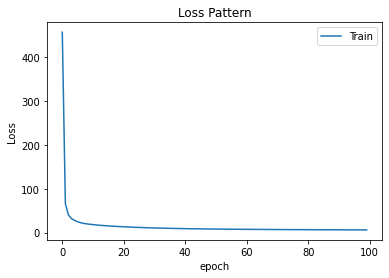

In [12]:
plt.plot(results.history['loss'])
plt.title('Loss Pattern')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right');
plt.show()

## Test

In [13]:
X_train_pred = vae_model.predict(X_train_VAE)
error_vector = VariationalAutoencoderModel.get_error_term(X_train_pred, X_train_VAE, _rmse=False)
error_thresh = np.quantile(error_vector, 0.999)

print(error_thresh)

# Measure the error between the train set and its output and generates an error vector representing the error of each term
# Find an extreme value on the vector to use as the error threshold

/home/andressa.amaral/.local/lib/python3.6/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


0.07498107244961567


In [14]:
X_pred_VAE = vae_model.predict(X_test_VAE)

# If the error of the vector is higher than the defined threshold it detects an attack

error_vector = VariationalAutoencoderModel.get_error_term(X_pred_VAE, X_test_VAE, _rmse=False)
attacks = (error_vector > error_thresh)
print(attacks)

np.count_nonzero(attacks) / len(attacks) # Percentage of attacks

[False False False ...  True  True  True]


0.9688117716782733

## Metrics

In [15]:
print(classification_report(Y_test_VAE, attacks, digits = 6))

              precision    recall  f1-score   support

         0.0   0.529831  0.999499  0.692546     13976
         1.0   0.999991  0.985090  0.992485    831375

    accuracy                       0.985328    845351
   macro avg   0.764911  0.992294  0.842515    845351
weighted avg   0.992218  0.985328  0.987526    845351



In [16]:
# Examinig the latent space generated by the encoder

X_encoded = encoder.predict(X_test_VAE)

pca = PCA(n_components=2)
X_analysis = pca.fit_transform(X_encoded)

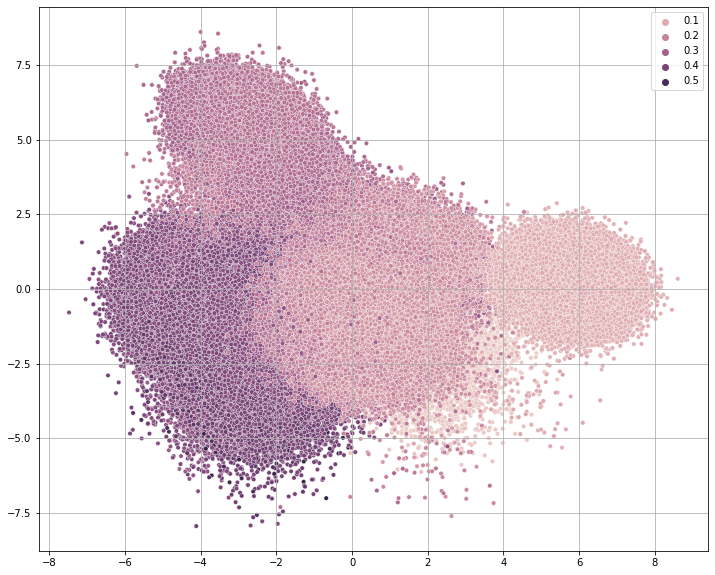

In [17]:
plt.figure(figsize = (12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = error_vector)
plt.grid()
plt.show()

# Darker clusters indicate that the error is higher

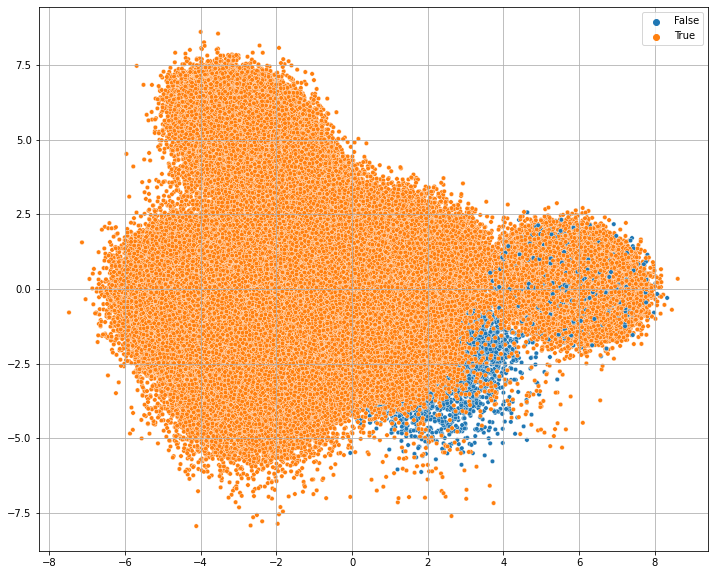

In [18]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = attacks)
plt.grid()
plt.show()

# Orange ones are anomalies

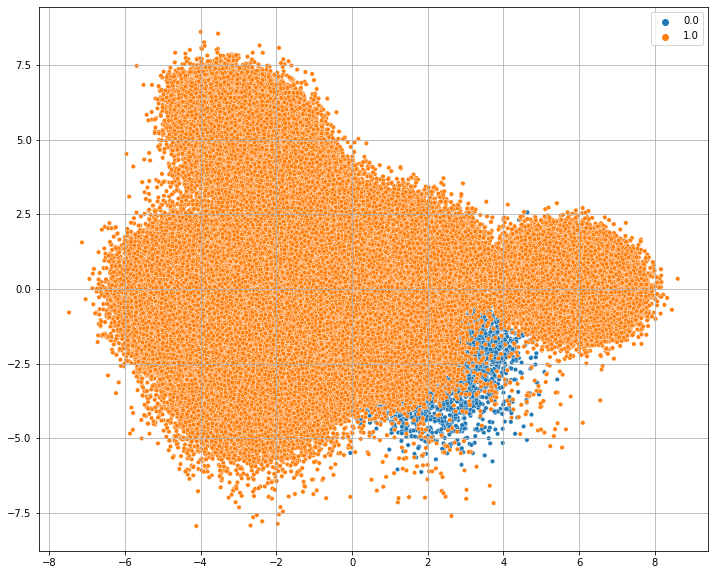

In [19]:
plt.figure(figsize = (12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = Y_test_VAE)
plt.grid()
plt.show()

# Ground truth